In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob

In [2]:
dir_plots = './plots'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_total = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_total.dta'))
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [3]:
df1 = df_acc_total[["mergeid", "GGIR_mean_ENMO_total", "OxCGRT_stay_at_home", "OxCGRT_stringency_index", "country"]].copy()
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [4]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [5]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [6]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df

df = map_bmi_num(df)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

df.loc[:, 'OxCGRT_stay_at_home'] = df['OxCGRT_stay_at_home'].replace({
    'No measures': 'No restrictions',
    "Require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips": 'Essential only',
    "Recommend not leaving house": 'Stay at home',
})


In [7]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [8]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [9]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])

In [10]:
df['disease'].value_counts()

control    383
d1         241
d4          68
d3          48
d5          46
d2          44
d7          20
d6           6
Name: disease, dtype: int64

<AxesSubplot:title={'center':'Total number in each group'}, xlabel='groups', ylabel='count'>

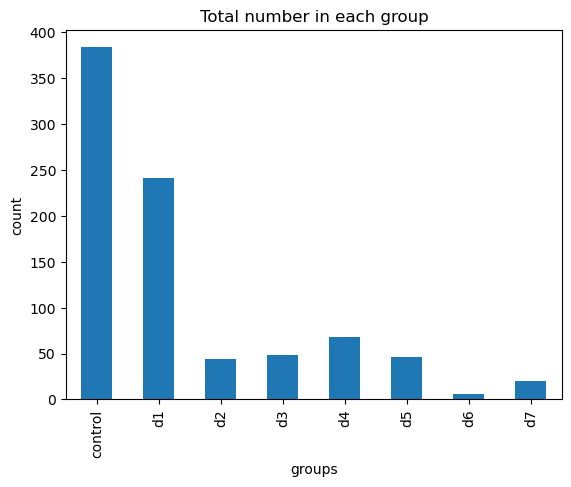

In [11]:
disease_table = pd.crosstab(index=df['disease'], columns='count')
#labels = ["control", "Hypertension", "Diabetes", "OA", "Hyp_Dia", "Hyp_OA", "Dia_OA", "Hyp_Dia_OA"]
disease_table.plot(
    kind='bar', 
    title="Total number in each group", 
    ylabel="count",
    xlabel= "groups",
    #xticks=labels,
    legend=False
    )


In [12]:
st_dev_age = df.groupby('disease')['age'].agg(['mean', 'std']) 
st_dev_age

,mean,std
disease,,
control,66.881985,8.529482
d1,70.952283,9.454537
d2,70.270455,8.690374
d3,70.043751,9.603056
d4,71.286765,7.044717
d5,70.734783,8.596956
d6,72.516667,7.085878
d7,71.655000,8.660587


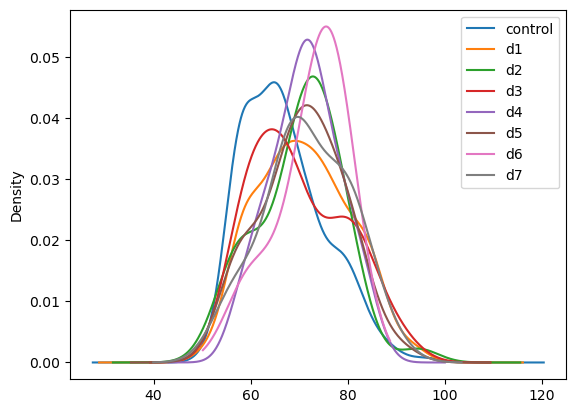

In [13]:
df.groupby('disease')['age'].plot.kde()
#Wie kann ich eine legende einfügen?
plt.legend()
plt.show()

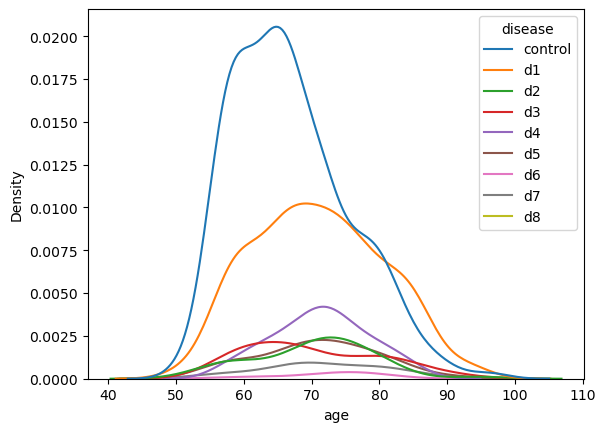

In [14]:
# wenn du seaborn benutzt. kannst du die kde relativ zueinander ploten. heißt du siehst wie die samples tatsächlich verteilt sind
sns.kdeplot(data=df, x='age', hue='disease', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
plt.show()

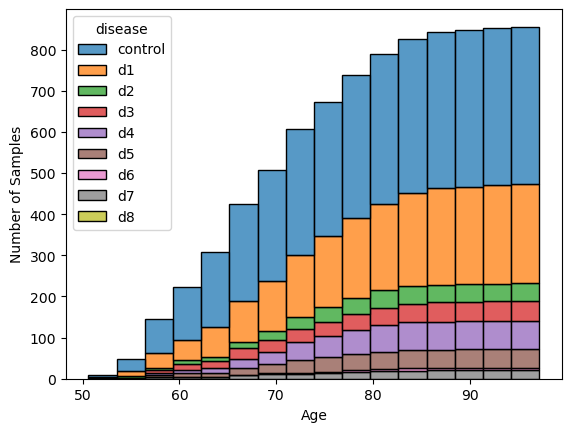

In [15]:
# kummulativer histplot
sns.histplot(data=df, x='age', hue='disease', cumulative=True, multiple='stack', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
plt.ylabel("Number of Samples")
plt.xlabel("Age")
plt.show()

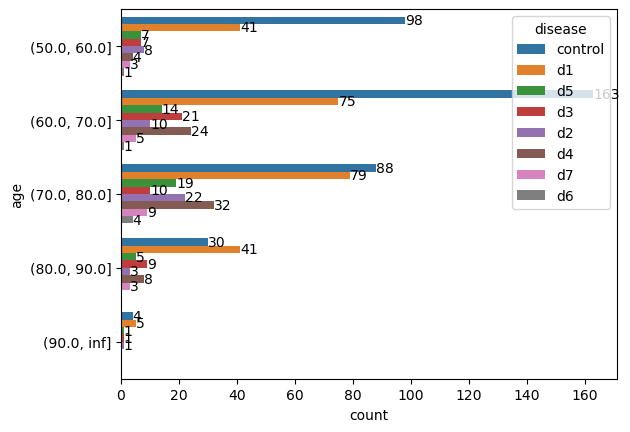

In [16]:
data = pd.DataFrame({
    "age": pd.cut(df["age"], bins=[50, 60, 70, 80, 90, np.inf]),
    "disease": df["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="age", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("age")
plt.show()

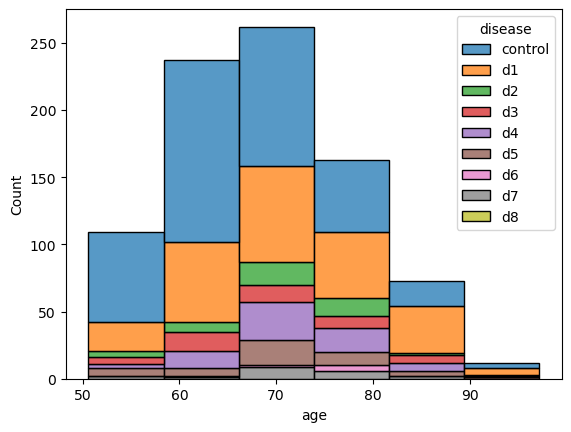

In [17]:
# histplot nach alter
sns.histplot(data=df, x='age', hue='disease', bins=6, multiple='stack', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
plt.show()

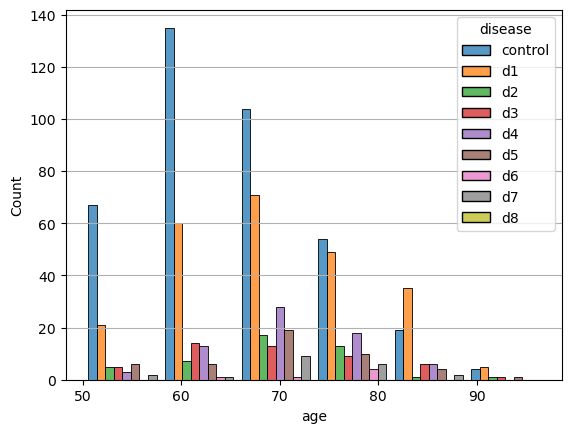

In [18]:
# histplot nach alter
p = sns.histplot(data=df, x='age', hue='disease', bins=6, multiple='dodge', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
p.yaxis.grid(True) 
plt.show()

disease
control    AxesSubplot(0.125,0.11;0.775x0.77)
d1         AxesSubplot(0.125,0.11;0.775x0.77)
d2         AxesSubplot(0.125,0.11;0.775x0.77)
d3         AxesSubplot(0.125,0.11;0.775x0.77)
d4         AxesSubplot(0.125,0.11;0.775x0.77)
d5         AxesSubplot(0.125,0.11;0.775x0.77)
d6         AxesSubplot(0.125,0.11;0.775x0.77)
d7         AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

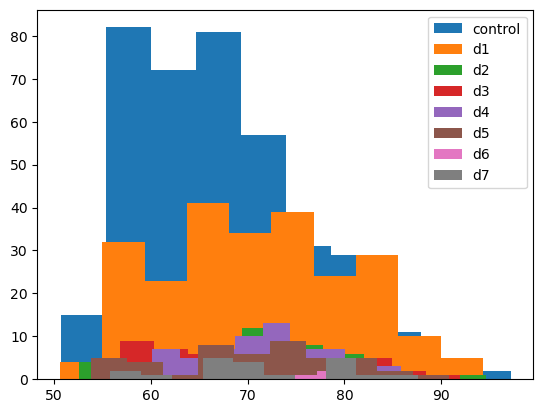

In [19]:
df.groupby('disease')['age'].hist(grid=False,legend=True)

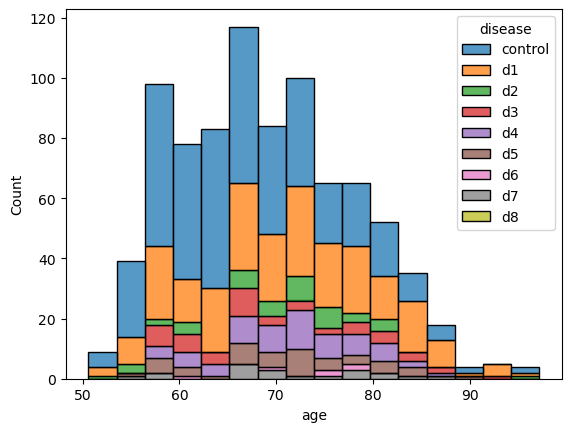

In [20]:
# histplot nach alter
sns.histplot(data=df, x='age', hue='disease', multiple='stack', hue_order=['control', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8'])
plt.show()

In [21]:
st_dev_BMI = df.groupby('disease')['bmi'].agg(['mean', 'std']) # for mean and std deviation
st_dev_BMI

,mean,std
disease,,
control,25.851241,4.853359
d1,28.207152,5.659255
d2,28.617814,4.356346
d3,26.259079,5.669901
d4,28.386495,8.002335
d5,29.501451,6.631926
d6,26.817510,3.482822
d7,28.093996,12.739242


disease
control    AxesSubplot(0.125,0.11;0.775x0.77)
d1         AxesSubplot(0.125,0.11;0.775x0.77)
d2         AxesSubplot(0.125,0.11;0.775x0.77)
d3         AxesSubplot(0.125,0.11;0.775x0.77)
d4         AxesSubplot(0.125,0.11;0.775x0.77)
d5         AxesSubplot(0.125,0.11;0.775x0.77)
d6         AxesSubplot(0.125,0.11;0.775x0.77)
d7         AxesSubplot(0.125,0.11;0.775x0.77)
Name: bmi, dtype: object

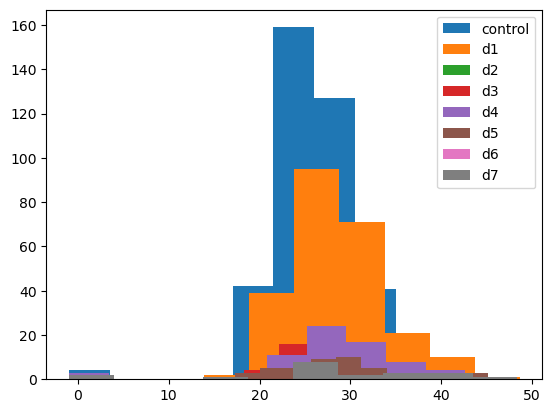

In [22]:
df.groupby('disease')['bmi'].hist(grid=False,legend=True)

In [23]:
c_sex = df.groupby('disease')['female'].value_counts().astype(int)
p_sex = df.groupby('disease')['female'].value_counts(normalize=True).mul(100).round(1).astype(str)
count_sex = pd.concat([c_sex,p_sex],keys=['counts','%']).unstack()
count_sex.T

counts                                   %                          \
disease control   d1  d2  d3  d4  d5 d6  d7 control    d1    d2    d3    d4   
female                                                                        
0           163  106  20  12  37  10  2   7    42.6  44.0  45.5  25.0  54.4   
1           220  135  24  36  31  36  4  13    57.4  56.0  54.5  75.0  45.6   

                           
disease    d5    d6    d7  
female                     
0        21.7  33.3  35.0  
1        78.3  66.7  65.0

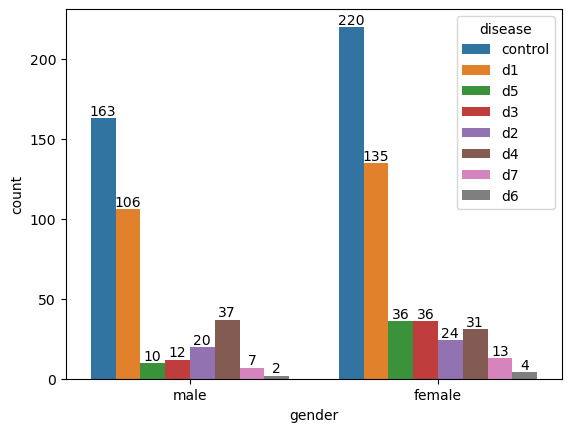

In [24]:
data = pd.DataFrame({
    "gender": df["female"],
    "disease": df["disease"]
})

plt.figure()
ax = sns.countplot(data=data, x="gender", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(["male", "female"])
plt.show()

In [25]:
count_origin = (
    df.groupby('disease')
.country
.value_counts()
.unstack()
)
count_origin

,Germany,Sweden,Spain,Italy,France,Denmark,Belgium,Czech Republic,Poland,Slovenia
disease,,,,,,,,,,
control,49,27,43,32,39,22,44,39,46,42
d1,33,30,16,22,18,8,17,27,32,38
d2,6,2,3,2,2,1,7,6,9,6
d3,7,2,3,2,11,4,5,5,9,0
d4,12,5,5,3,4,0,1,10,18,10
d5,8,3,1,5,4,1,5,9,8,2
d6,0,1,0,0,1,0,1,1,1,1
d7,1,1,1,1,0,0,1,8,6,1


<AxesSubplot:ylabel='disease'>

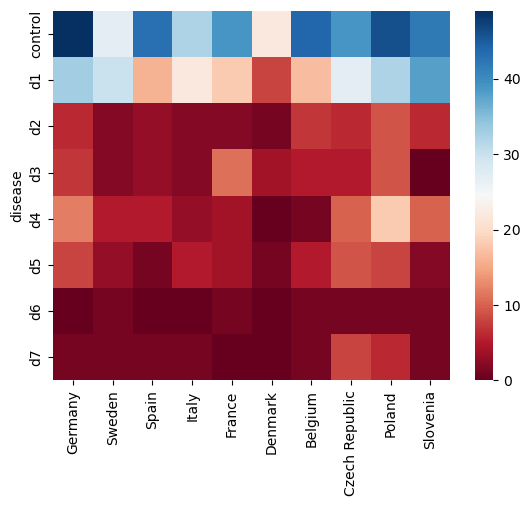

In [26]:
sns.heatmap(count_origin, 
            cmap='RdBu'
            )

<AxesSubplot:ylabel='Density'>

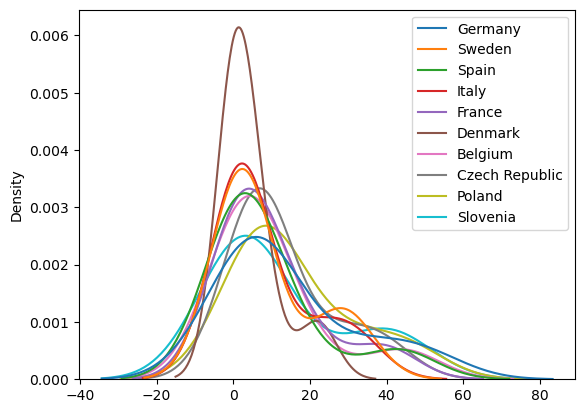

In [27]:
sns.kdeplot(data=count_origin)

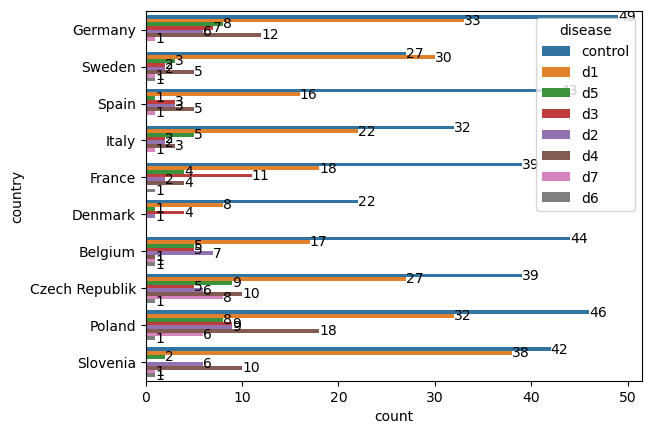

In [28]:
data = pd.DataFrame({
    "country": df["country"],
    "disease": df["disease"]
})

plt.figure()
ax = sns.countplot(data=data, y="country", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
ax.set_yticklabels(["Germany", "Sweden", "Spain", "Italy", "France",  "Denmark", "Belgium", "Czech Republik", "Poland", "Slovenia"])
plt.show()

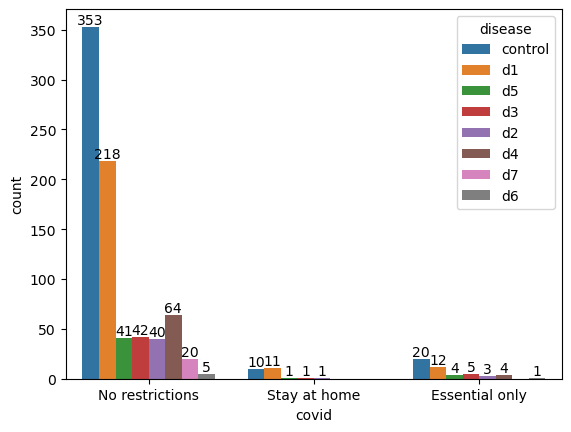

In [29]:
data = pd.DataFrame({
    "covid": df["OxCGRT_stay_at_home"],
    "disease": df["disease"]
})

plt.figure()
ax = sns.countplot(data=data, x="covid", hue="disease")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

<AxesSubplot:ylabel='disease'>

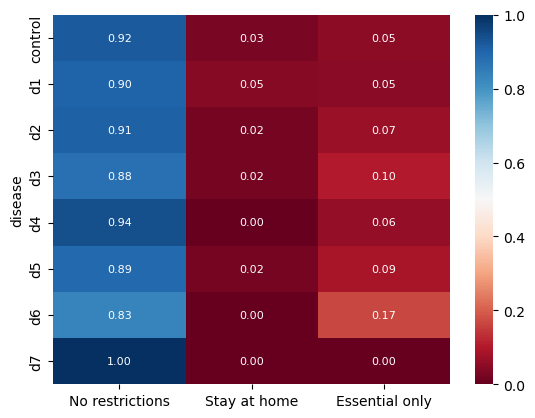

In [30]:
covid = (
    df.groupby('disease')
.OxCGRT_stay_at_home
.value_counts(normalize=True)
.unstack()
)
sns.heatmap(covid, 
            cmap='RdBu',
            annot=True, fmt=".2f", 
            annot_kws={'fontsize': 8}
            )

    positive correlation -> 1 (blue)
    negative correltation -> 0 (red)

In [31]:
df['OxCGRT_stringency_index'] #muss noch beachtet werden

0      11
1      11
2      49
3      81
4      11
       ..
851     0
852     0
853     0
854     0
855     0
Name: OxCGRT_stringency_index, Length: 856, dtype: int8